In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn import preprocessing
import warnings
import copy
warnings.filterwarnings('ignore')

In [50]:
# Load the merged dataset

df_merged = pd.read_csv('cleaned_merged_data.csv')

In [51]:
# Create a copy of the df_merged with categorical columns with string classes converted to numeric index

df_merged_corr = df_merged.copy()

In [52]:
df_merged.shape

(1413701, 82)

In [53]:
# Find the correlation between all the variables w.r.t to the Target to get the top 20 feature to focus on
# Convert the categorical variable to the numeric columns


for col in list(df_merged_corr.select_dtypes(include=['object']).columns):
    df_merged_corr[col] = df_merged_corr[col].astype('category').cat.codes

corr = df_merged.corr().abs()

In [54]:
# Ignoring the column SK_ID_CURR and checking the correlation of the variables w.r.t the different columns. 
corr = df_merged_corr[df_merged_corr.columns[1:]].corr()['TARGET'][:-1]

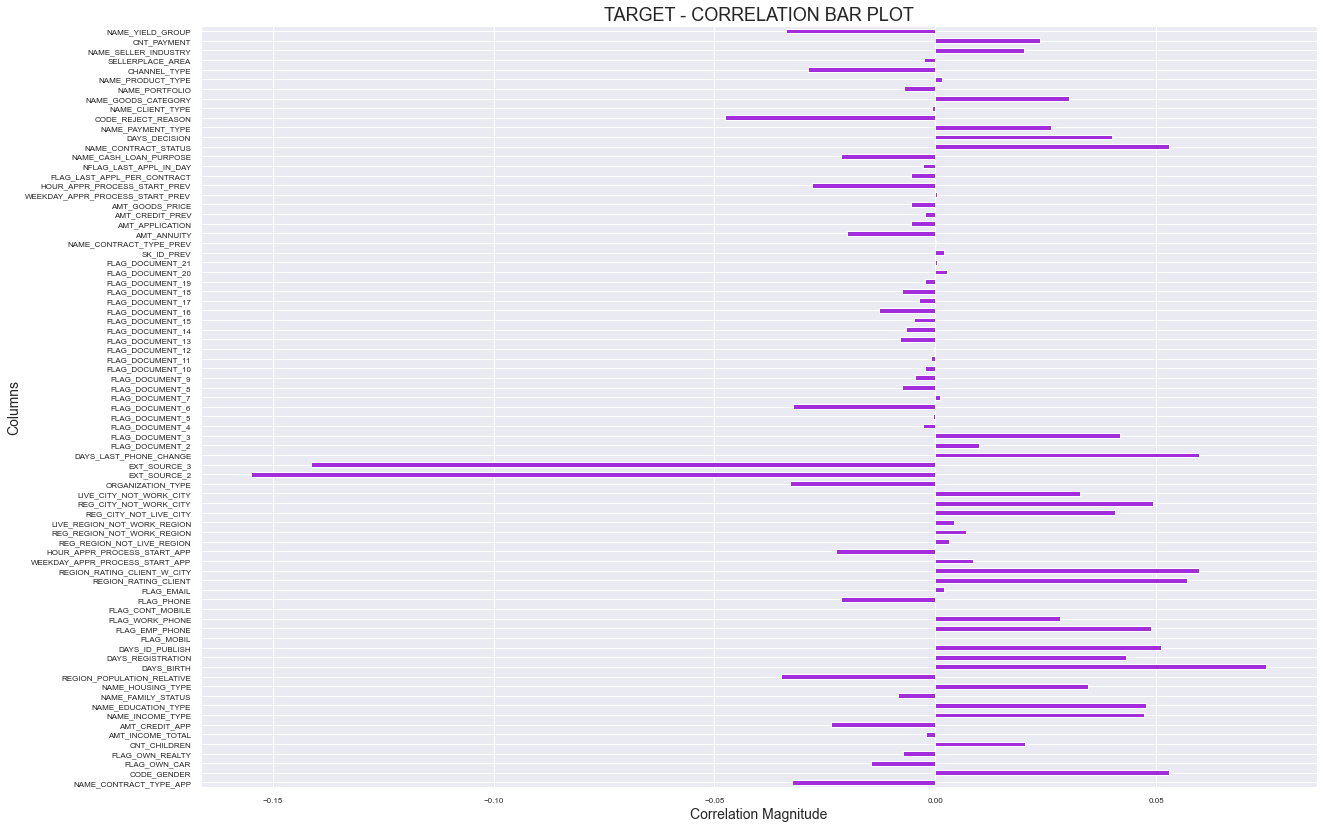

In [55]:
# Plot the correlations of all the variables w.r.t to the Target Variable
list_colr = [random.random() for x in range(3)]
ax = corr[1:].plot(kind='barh', figsize=(20,14), color=list_colr, fontsize=8, grid=True)
ax.set_title("TARGET - CORRELATION BAR PLOT", fontsize=18)
ax.set_xlabel("Correlation Magnitude", fontsize=14)
ax.set_ylabel("Columns", fontsize=14)
plt.show()

### Top features Correlating with the target variable

In [56]:
# Print top-20 correlated columns and check which ones can be used for further analysis.

sorted_corr = corr.sort_values(kind="quicksort")
print(f"Top 20 correlated features w.r.t target : \n\n{[x for x in sorted_corr[0:20].keys()]}")

Top 20 correlated features w.r.t target : 

['EXT_SOURCE_2', 'EXT_SOURCE_3', 'CODE_REJECT_REASON', 'REGION_POPULATION_RELATIVE', 'NAME_YIELD_GROUP', 'ORGANIZATION_TYPE', 'NAME_CONTRACT_TYPE_APP', 'FLAG_DOCUMENT_6', 'CHANNEL_TYPE', 'HOUR_APPR_PROCESS_START_PREV', 'AMT_CREDIT_APP', 'HOUR_APPR_PROCESS_START_APP', 'FLAG_PHONE', 'NAME_CASH_LOAN_PURPOSE', 'AMT_ANNUITY', 'FLAG_OWN_CAR', 'FLAG_DOCUMENT_16', 'NAME_FAMILY_STATUS', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_18']


The columns to use for the analysis, since there are 82 columns, we are picking up 10 columns(makes sense it terms of exploration) from the top 20 targert correlated feature for our univariate and bivariate analysis.

* The columns **EXT_SOURCE_2** and **3** all have no information on what these columns are, though they are among the top correlated variables, they don't give us a dimension along which we could make analysis.

* **CODE_REJECT_REASON** - Why the previous loan got rejected, a good potential column to be used for the analysis.

* **REGION_POPULATION_RELATIVE** : Influence of the population magnitude in the nearby area, seems to a unique influencer, but it is worth the experience.

* **NAME_YIELD_GROUP** : Grouped interest rate into small, medium and high for previous application, a good indicator to explore, since that can speak about population of different interest rates.

* **ORGANISATION_TYPE** : The organization for which client works, speaks for the sector of which he works and talks about his current financial status and a futuristic financial security.

* **NAME_CONTRACT_TYPE_APP** : Whether loan is cash or revolving(credit), is also a good dimension to explore within the default or non defaults.

* **FLAG_PHONE** :  Unique and interesting attribute to explore for loan defaults.

* **FLAG_DOCUMENT_6** : speaks for the fact that whether document 6 was provided or not, no information on what this document is. 

Since the columns EXT_SOURCE_1, 2, 3 and FLAG_DOCUMENT_6 have no information of help, let's pick 4 more columns from the top-20 columns. 

* **AMOUNT_CREDIT_APP** : The credit amount applied for the current application, should also be a good indicator to state loans under what amount are safe to be approved and not.

* **AMT_ANNUITY** : Installment, similar to the above amount(Previous loan), above what value of the annuity is more prone to be default across which subsection, should also be an interesting column for exploration.

* **FLAG_OWN_CAR** : Whether ownership of car for a customer is a significant factor of loan default or not, another dimension to explore the loan applicant's personality.

* **NAME_FAMILY_STATUS** : Family status (single, married, widowed, separate), another dimension which speaks of the finanical responsibilities owned by the individual, is also a significant factor explore the loan default behvior.


**Going on with the analysis, we will analyse the 10 columns filtered based on the correlation w.r.t the target.**


In [57]:
# Split the df_merged into two groups, Late-Payment -> 1 and on-time -> 0 

df_merge_tar_0 = df_merged[df_merged['TARGET'] == 0]
df_merge_tar_1 = df_merged[df_merged['TARGET'] == 1]

### Exploring the Late-Payment population 

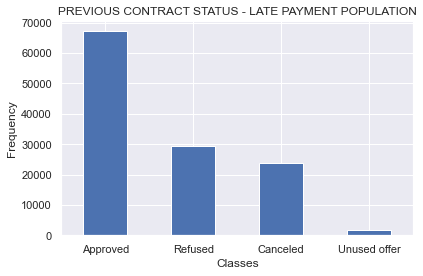

In [58]:
# Check the value counts for the NAME_CONTRACT_STATUS for the late-payment population
df_merge_tar_1['NAME_CONTRACT_STATUS'].value_counts().plot(kind='bar')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('PREVIOUS CONTRACT STATUS - LATE PAYMENT POPULATION')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Majority of current application late-payment loans were approved in the previous records. This proves that or current applications have a lot of False Positive cases 

In [59]:
# Group df_merge_tar_1 based on the NAME_CONTRACT_STATUS
# Create a dictionary of the subcategory dataframes
# {'Approved' : df}
def create_sub_dfs(df, list_categ):
    dict_df = {}
    for categ in list_categ:
        dict_df[categ] = df[df['NAME_CONTRACT_STATUS'] == categ]
    return dict_df


In [60]:
# FOUR BUCKET WOULD BE APPROVED, REFUSED, CANCELED, UNUSED OFFER\

dict_bucket_tru_1 = create_sub_dfs(df_merge_tar_1, ['Approved', 'Refused', 'Canceled', 'Unused offer'])
dict_bucket_tar_0 = create_sub_dfs(df_merge_tar_0, ['Approved', 'Refused', 'Canceled', 'Unused offer'])

In [61]:
# For the categorical variables lets do a barplot
# For the numeric columns we will do a boxplot
list_categ = ['CODE_REJECT_REASON', 'NAME_YIELD_GROUP', 'ORGANIZATION_TYPE', 'NAME_CONTRACT_TYPE_APP', 'FLAG_OWN_CAR', 'NAME_FAMILY_STATUS', 'FLAG_PHONE']
list_numeric = ['REGION_POPULATION_RELATIVE', 'AMT_CREDIT_APP', 'AMT_ANNUITY']

In [62]:
### Frequency plot for the categorical variable among top-10 features

def plot_categ(nrows, ncols, df, categ_cols, figsize):

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    index = 0
    if nrows > 1:
        for row in range(nrows):
            for col in range(ncols):
                if index < len(categ_cols):
                    r = random.random()
                    b = random.random()
                    g = random.random()
                    y = [val for key, val in df[categ_cols[index]].value_counts().iteritems()]
                    x = [n for n in range(len(y))]
                    ax[row][col].bar(x, y, color=(r,g,b)) 
                    ax[row][col].set_xlabel('Categories', fontsize=12)
                    ax[row][col].set_ylabel('Frequency', fontsize=12)
                    ax[row][col].set_title(f'{categ_cols[index]} - Class Frequency Plot')
                    plt.sca(ax[row][col])
                    plt.xticks(range(len(x)), [key for key, val in df[categ_cols[index]].value_counts().iteritems()],rotation=90)
                    ax[row][col].grid()
                else :
                    ax[row, col].axis('off')

                index +=1
    else:
        for row in range(nrows):
            for col in range(ncols):
                if index < len(categ_cols):
                    r = random.random()
                    b = random.random()
                    g = random.random()
                    y = [val for key, val in df[categ_cols[index]].value_counts().iteritems()]
                    x = [n for n in range(len(y))]
                    ax[col].bar(x, y, color=(r,g,b)) 
                    ax[col].set_xlabel('Categories', fontsize=12)
                    ax[col].set_ylabel('Frequency', fontsize=12)
                    ax[col].set_title(f'{categ_cols[index]} - Class Frequency Plot')
                    plt.sca(ax[col])
                    plt.xticks(range(len(x)), [key for key, val in df[categ_cols[index]].value_counts().iteritems()],rotation=90)
                    ax[col].grid()
                else :
                    ax[col].axis('off')

                index +=1
        

    plt.tight_layout()
    plt.show()

In [63]:
# Box plot for the numerical columns
# Normalize the numeric columns so that the values can be plotted on the same scale
def plot_box(df, list_cols, fig_size):
    
    plt.figure(figsize=fig_size)
    min_max_scaler = preprocessing.MinMaxScaler()
    df_numer = df[list_cols]
    x_scaled = min_max_scaler.fit_transform(df_numer)
    df_normalized = pd.DataFrame(x_scaled)
    df_normalized.columns = list_cols
    sns.boxplot(y="variable", x="value", data=pd.melt(df_normalized), orient='h')
    plt.xlabel('Normalized Value', fontsize=15)
    plt.ylabel('Features', fontsize=15)         
    plt.title('Box Plot Analysis - Numeric Columns', fontsize=20)
    plt.tight_layout()
    plt.show()

### Exploring the Non-Defaulter population 

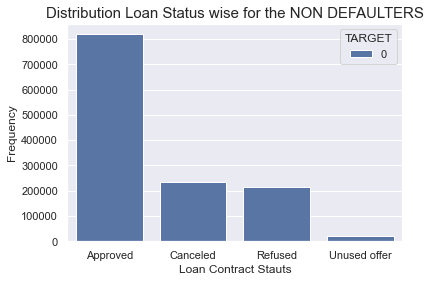

In [64]:
#Plotting a barplot for the value counts for the NON DEFAULTERS
fig, ax = plt.subplots()
ax=sns.countplot(data=df_merge_tar_0,x='NAME_CONTRACT_STATUS',order=df_merge_tar_0['NAME_CONTRACT_STATUS'].value_counts().index, hue='TARGET')
plt.xlabel('Loan Contract Stauts',size=12)
plt.ylabel('Frequency',size=12)
plt.title('Distribution Loan Status wise for the NON DEFAULTERS',size=15)
plt.show()

# Univariate Analysis

## Target = 1 (Late payment) and Previously Approved Bucket

###  Plot the bar charts for the categorical variable in the previous approved with current late payment(Target=1)

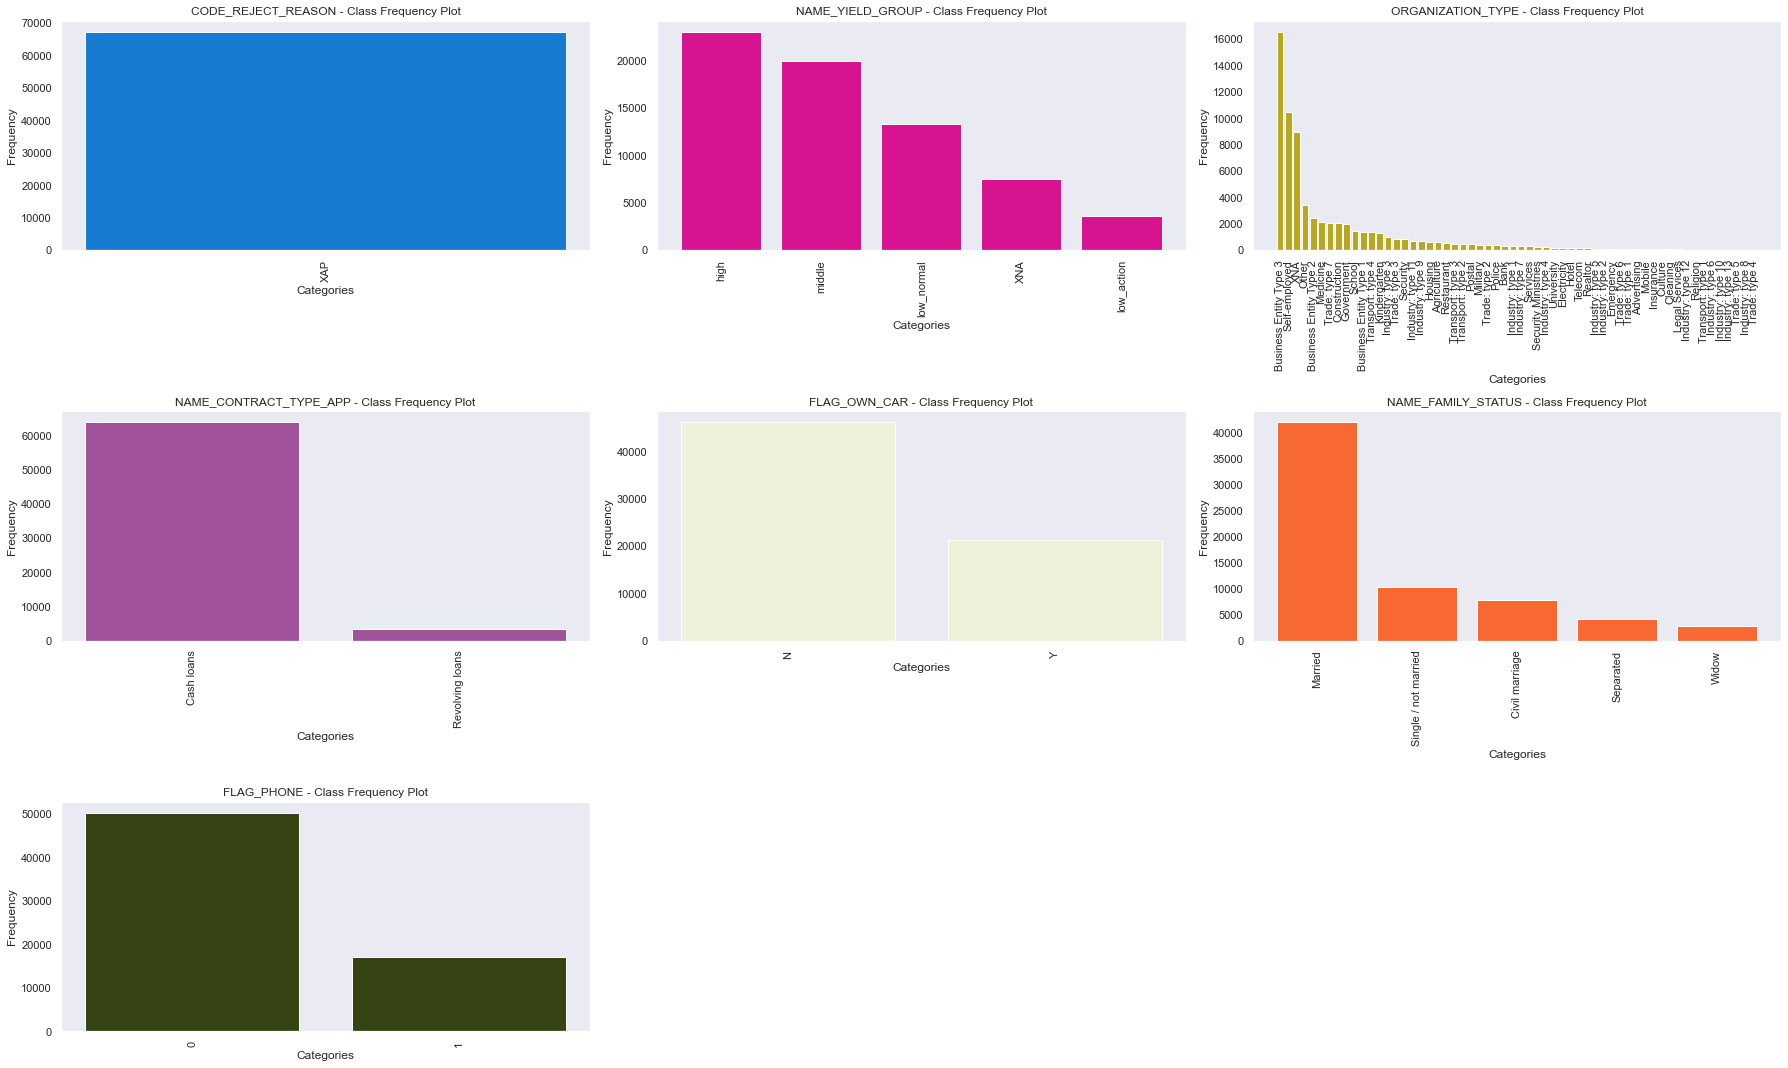

In [65]:
# Plot the
fig_size = (25, 15)
plot_categ(3, 3, dict_bucket_tru_1['Approved'], list_categ, fig_size)

### Insights : 


The CODE_REJECT_REASON 

* It has only one class XAP for all the approved loans, which points to the fact the reason for the previous loan reject is missing. So w.r.t the CODE_REJECT_REASON, we cannot state if the current late payment of this group has an code reject reason as an indicator for it.


The NAME_YIELD_GROUP 

* clearly indicates that population with high interest rates in previous loans is the late payment population in the current application but we also see that event the middle interest rate population is also not behind in the late payment procedure. The low_normal and low_action have late payment population almost half or less than half compared to the high and medium rate population.


ORGANIZATION_TYPE 

* strongly indicates that customers with organization as "Business Entity Type 3" has made most late payments among the previously approved loan, which points to the fact that current organisation should be very speculative before giving loans to customers beloning to this organisation type.

NAME_CONTRACT_TYPE_APP 

* The customers with cash loans in the current application are defaulting more for late payments compared to the revolving loans. Therefore, organisation should have strong filter criteria for the cash loan applications.

FLAG_OWN_CAR 

* The majority of late payment customer in the group don't have a car which points to low financial strength with the customer. Another aspect which the organisation should consider looking into.

NAME_FAMILY_STATUS 

* The married customers are the most defaulted ones in the current application, which points to the fact there are financial liabilities for the customers. There should be strong filters for Married status customers before approving loans.

FLAG_PHONE

* Another unique and strong indicator, majority of customer with late payments in approved bucket, didn't provide home phone details. Going forward organisation should make sure they get home phone details from the customer and if in case he is not providing the details, there should be a thorough check on his background before the loan is approved.

###  Box plot for the categorical variable in the previous approved with current late payment(Target=1)

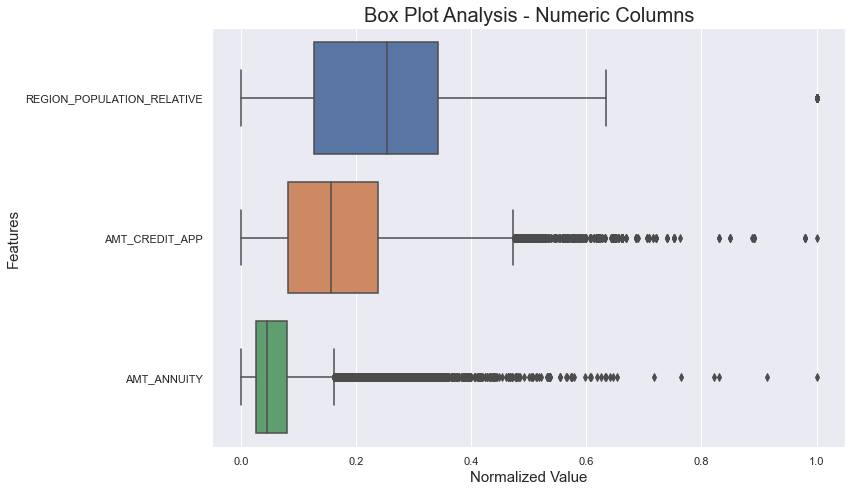

In [66]:
fig_size = (12, 7)
plot_box(dict_bucket_tru_1['Approved'], list_numeric, fig_size)

#### The issue with the above box plots is that they all are normalized between 0-1 and so a column specific magnitude analysis cannot be done here. Let's do a historgram plot for the numeric columns to understand it better.

###  Histogram plot for the categorical variable in the previous approved with current late payment(Target=1)

In [67]:
def plot_hist(df, list_cols, fig_size):
    
    fig, ax = plt.subplots(1, 3, figsize=fig_size)
    for j, col in enumerate(list_cols):
        tup_color = [random.random() for x in range(3)]
        df.hist(column=col, bins=100, ax=ax[j], alpha=0.5, color=tup_color)
        ax[j].set_title(f"Histogram - {col}", fontsize=18)
        ax[j].set_xlabel("Attribute Values - Bins", fontsize=12)
        ax[j].set_ylabel("Frequency", fontsize=12)
        

    plt.tight_layout()
    plt.show()
        
        
        
    
    

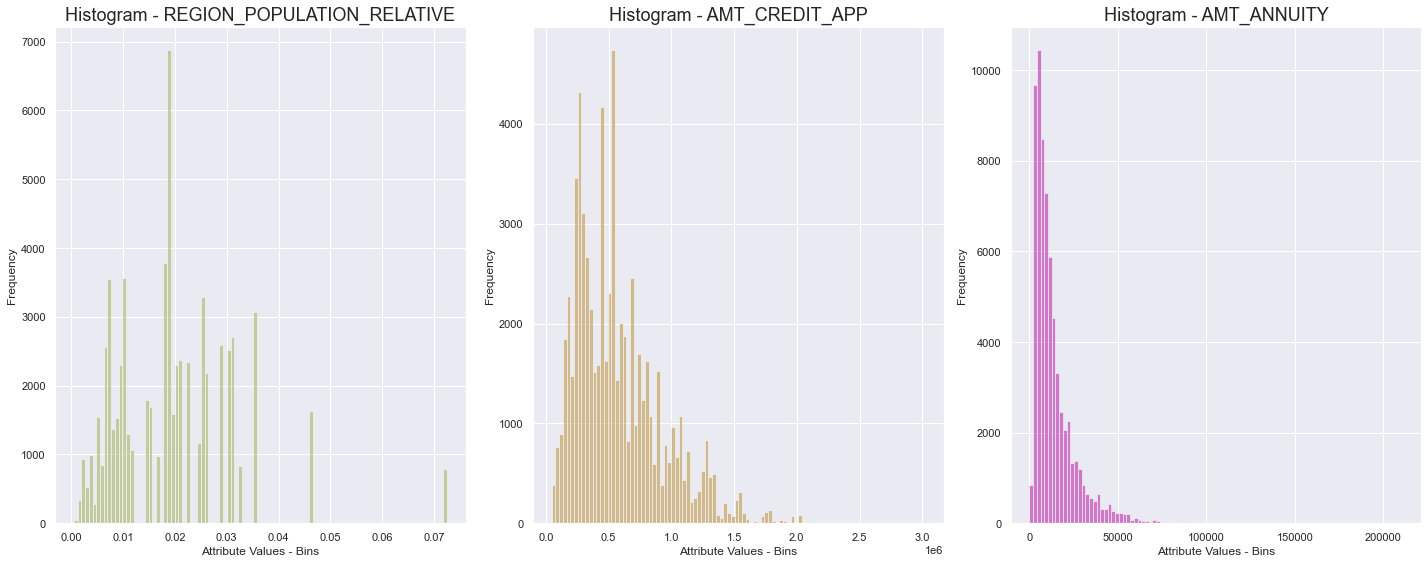

In [68]:
# Histogram plots for all the numeric columns of interest in Approved Target-1 bucket

fig_size = (20, 8)
plot_hist(dict_bucket_tru_1['Approved'], list_numeric, fig_size)

In [69]:
# Describe numeric features for statistical summary
for col in list_numeric:
    print(dict_bucket_tru_1['Approved'][col].describe())
    print()

count    67243.000000
mean         0.019257
std          0.011537
min          0.000533
25%          0.009657
50%          0.018801
75%          0.025164
max          0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64

count    6.724300e+04
mean     5.730567e+05
std      3.522811e+05
min      4.500000e+04
25%      2.888730e+05
50%      5.084955e+05
75%      7.551900e+05
max      3.020760e+06
Name: AMT_CREDIT_APP, dtype: float64

count     67243.000000
mean      13426.411873
std       12251.562305
min           0.000000
25%        5451.120000
50%        9490.770000
75%       16875.000000
max      210938.805000
Name: AMT_ANNUITY, dtype: float64



### Insights : 


REGION_POPULATION_RELATIVE - (Normalized population of a region where client lives)


* A huge peak can found in the attribute around 0.02 i.e. the normalized region population, which points to the fact the customers living in the region of that relative population are the ones who fall in the late payment category but got previous load approved. It would be of great interest to check if these regions are same, or there is some patterns in the regions, which might be leading to late payments from that region. For example, region relative population with high value could be congested area which points to low income of the applicant, whereas a low relative population in the areas can be an indicator person is living in a villa complex which points he belongs to a high income group.

AMT_CREDIT_APP - (Amount of credit applied for in the current application)

* The plot is a right skewed distribution with mean loan value = 5.730567e+05. It can be seen that late payments are not for the high value loans rather for the small value loan as this unimodal peak suggests. Therefore, it is worht inspecting the low amount loans for the customer base and see what are these low amount loans for which customers are making late payments.

AMT_ANNUITY - (Annuity for the previous application loan)

* The customer with low annuity amount are higher in number for the current late payment previously approved bucket. Another strong filter to check before approving loans. if the annuity is low, do make a thorough background check of the customer before approving it. 

## Target = 1 (Late payment) and Previously Refused

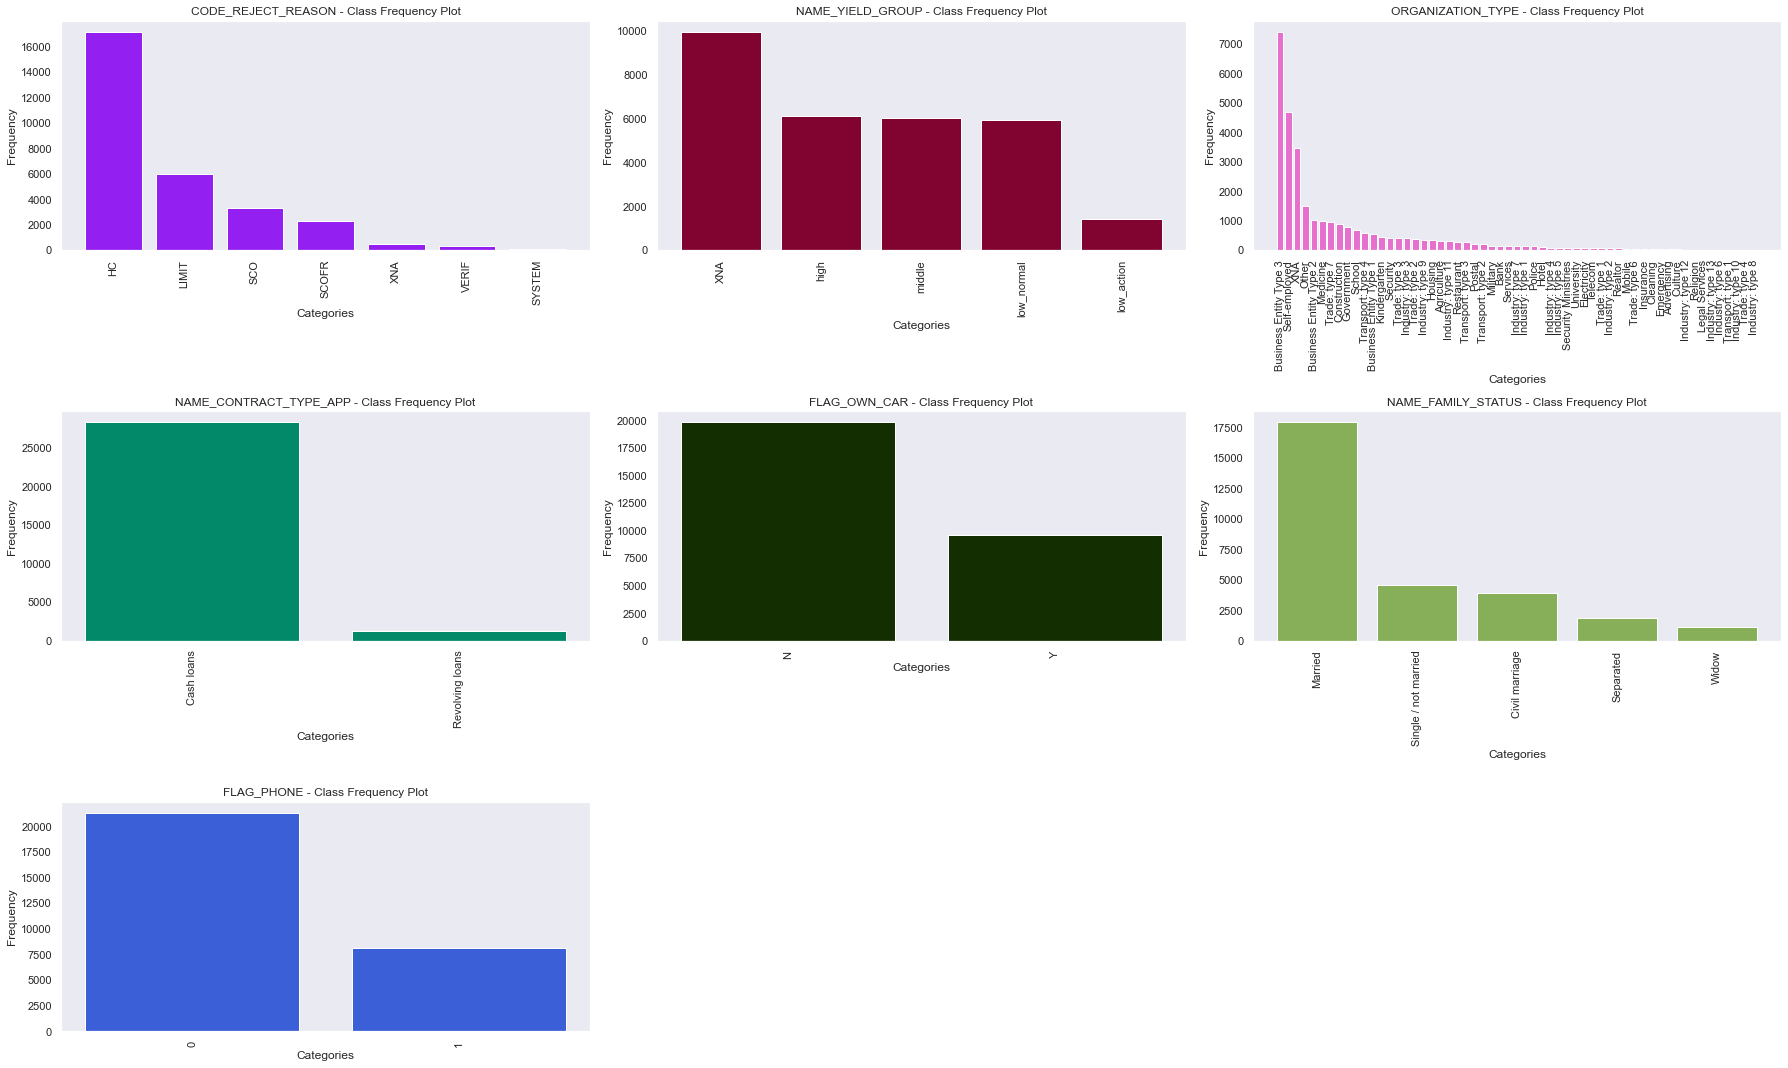

In [70]:
# Plot bar plot

fig_size = (25, 15)
plot_categ(3, 3, dict_bucket_tru_1['Refused'], list_categ, fig_size)

### Insights


The CODE_REJECT_REASON 

* The customers with reject code HC in the previous applications should be checked thoroughly before getting approved, since that's what the plot suggests. Rest customers belonging to all other classes have less than half of the proportion of what HC code reject population is.


The NAME_YIELD_GROUP 

* For majority of the customers in this population group have missing interest rate class, which means the dataset itself needs a correction and going forward we would want to make sure that interest rate is captured for all the customers in the database. Apart from the XNA class, we see high, middle and low_normal interest rate customers have almost uniform distribution in the bucket. That means majority of the previously rejected loans are with high, middle and low_normal interest rates. 


ORGANIZATION_TYPE 

* Majority of teh rejected loans are for business entity type -3 and self employeed customers, which points to the fact that financial dependance of customer on the performance of the business and self employment is an important factor and an uncertain factor. Therefore, majority of the loans for these sub populations is rejected.

NAME_CONTRACT_TYPE_APP 

* Majority of the customers who applied for cash loan previously and got rejected, defaulted in the current loan for late payments. The current organisation shouldn't approved the application of the customers whose loan got rejected due to ask for cash loans.

FLAG_OWN_CAR 

* Majority of the population that got rejected didn't have a car, which is again a strong indicator of the financial securance of the customer. The current organisation should make sure that the customer's whose historic loan got rejected and didn't have a car should be screen thoroughly before his application getting approved.

NAME_FAMILY_STATUS 

* Again married population's maximum previous loans got rejected compared to other family status groups. The current org should make sure, if the applicant is married and his previous loan got rejected, he should be screen thoroughly before his application gets accepted.

FLAG_PHONE

* For Majority with no phone record historically, the loan got rejected and the current organisation should make sure that, not to approve such historic loan applicant without thorough check.

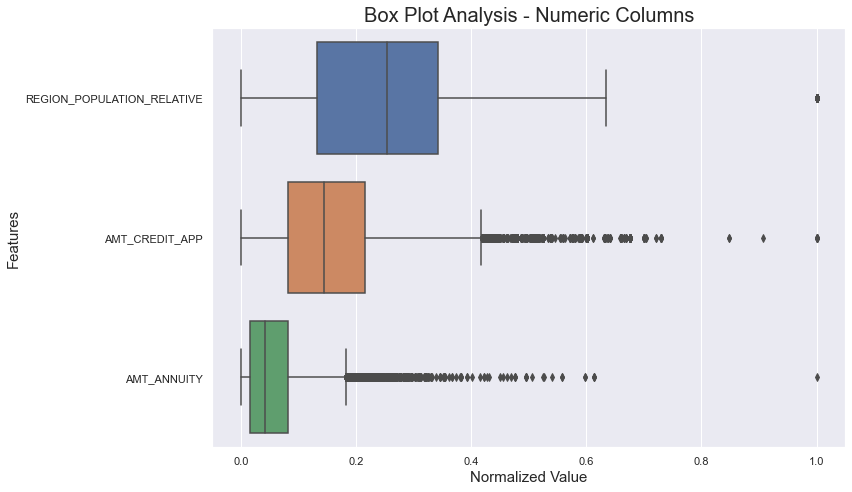

In [71]:
# Plot box plot

fig_size = (12, 7)
plot_box(dict_bucket_tru_1['Refused'], list_numeric, fig_size)

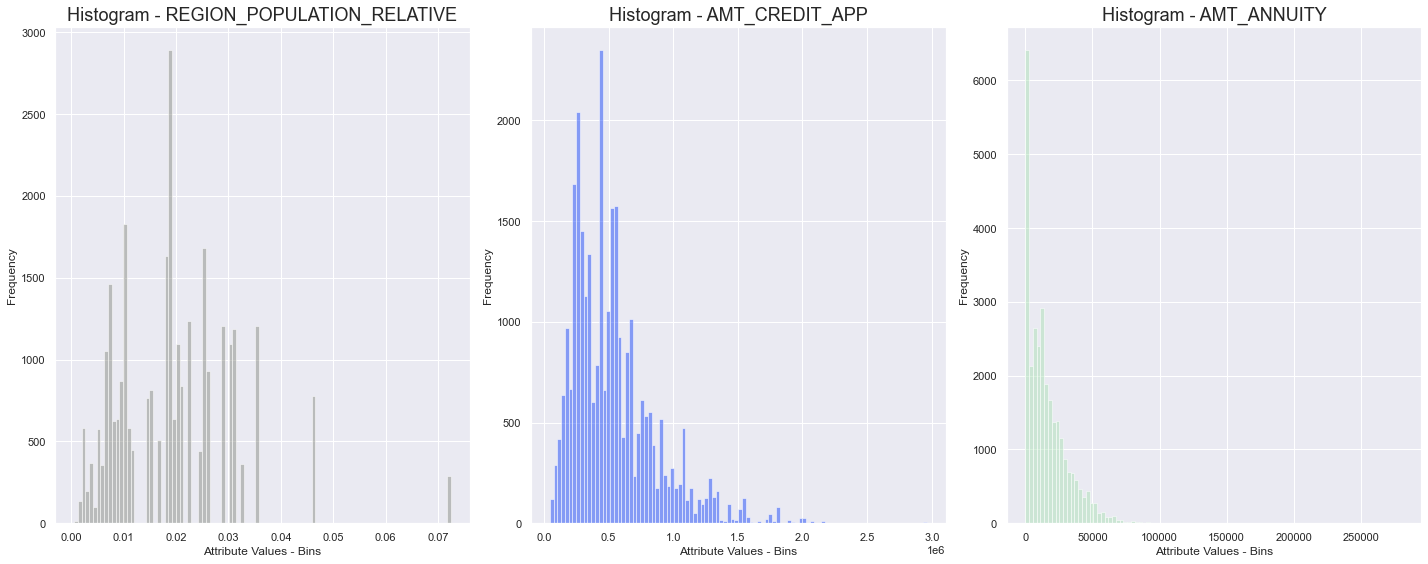

In [72]:
# Histogram plots

fig_size = (20, 8)
plot_hist(dict_bucket_tru_1['Refused'], list_numeric, fig_size)

In [73]:
# Describe numeric features for statistical summary
for col in list_numeric:
    print(dict_bucket_tru_1['Refused'][col].describe())
    print()

count    29438.000000
mean         0.019254
std          0.011299
min          0.000533
25%          0.010032
50%          0.018801
75%          0.025164
max          0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64

count    2.943800e+04
mean     5.353293e+05
std      3.265774e+05
min      4.500000e+04
25%      2.844000e+05
50%      4.635000e+05
75%      6.750000e+05
max      2.961000e+06
Name: AMT_CREDIT_APP, dtype: float64

count     29438.000000
mean      16473.159074
std       15585.485356
min           0.000000
25%        4407.367500
50%       11528.145000
75%       23123.880000
max      281027.250000
Name: AMT_ANNUITY, dtype: float64



### Insights

REGION_POPULATION_RELATIVE


* The normalized region population shows quite the same trend as the one shown by the approved bucket, the mode is for the distribution is somewhere near around 0.02 normalized population. This points to the fact that previous rejected loans and current defaulted population majorily live in the locatity of around 0.02 normalized population.

AMT_CREDIT_APP


* Right skewed distribution with mean loan amount applied = 5.353293e+05. For both previously rejected and accepted application the current loan applied and default is almost equal. The number of customers in the refused bucket are comparatively lesser compared to the approved bucket. Again we see, loans with low and medium credit amount are defaulting for late payment compared to high credit amount loans.

AMT_ANNUITY

* The annuity attribute has a hugh mode(Right skewed distribution) on the lower end of the annuity amount. The mean annuity for the previously refused population is 16473.15. This again shows the trend that low annuity is where customers are defaulting more compared to high annuity.




## Target = 0 (Non Defaulters) and Previously Approved Bucket

###  Plot for the categorical variable in the previous approved with current on time payment(Target=0)

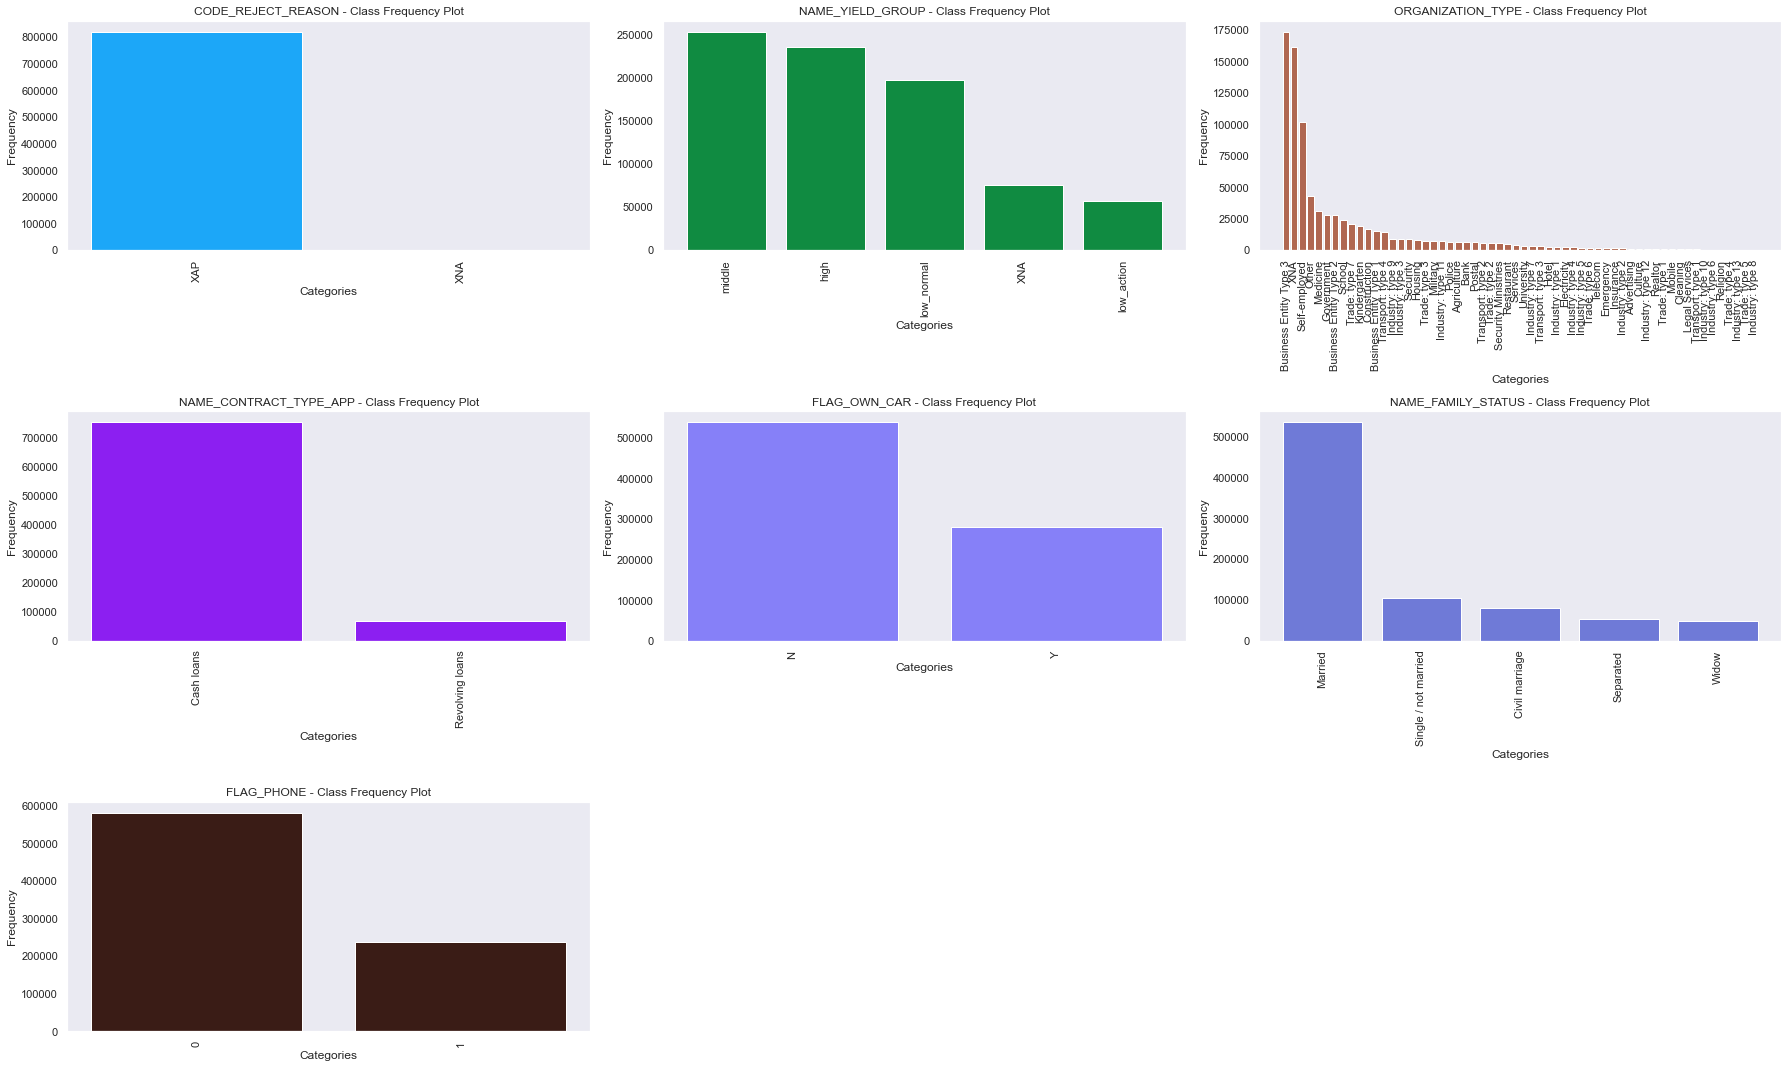

In [74]:
# Plot the
fig_size = (25, 15)
plot_categ(3, 3, dict_bucket_tar_0['Approved'], list_categ, fig_size)

 We can draw the following insights from the plots for categorical variable:
 
Category- CODE_REJECT_REASON 
* It has XAP and XNA for all the approved loans, pointing to the values whcih are missing in the previous application rejection reason. Thus this fields because of the missing values is not a good indicator if the person will be able to pay all his loans on time.

Category-NAME_YIELD_GROUP 
* By looking at the interest rates groups distribution, we can infer that interest rates that fall under middle range are the applicants that are more likely to pay the loans on time, followed  by the high interest rates.


Category- ORGANIZATION_TYPE 
* We see that the majority of the clients work for the "BUSINESS ENTITY TYPE 3" which have their previous loans approved. These are the clients which we should target often since they are less likely to default. 
* There is also a major chunk of the clients for whom the organisation type is missing. 
* The least amount of clients work in the "INDUSTRY: TYPE 8" whose previous loans were approved. 
* Almost equal amount of the non defaulters work in the organization type- "BUSINESS ENTITY TYPE 2" as well as the "SCHOOL"
* Similarily clients working in "POLICE", "AGRICULTURAL" and "POSTAL" have approximately same distribution whose previous loans were approved.
* Clients working in "MEDICINE" or "GOVERNMENT" are more likely to pay their loans on time rather than clients working for "INSURANCE" or "TELECOM"

Category-NAME_CONTRACT_TYPE_APP 
* Cash loans were provided in a huge number rather than the revolving loans for the clients whose previous loan were approved. 

Category- FLAG_OWN_CAR 
* Those who do not own a car are more likely to pay their installments on time.

Category- NAME_FAMILY_STATUS 
* Married people whose previous loans were approved are more likely to pay loan on time.

Category- FLAG_PHONE
* Majority of the people whose previous loan was approved have not provided their phone number.

###  Histogram plot for the numerical variable in the previous approved with current on time payment(Target=0)

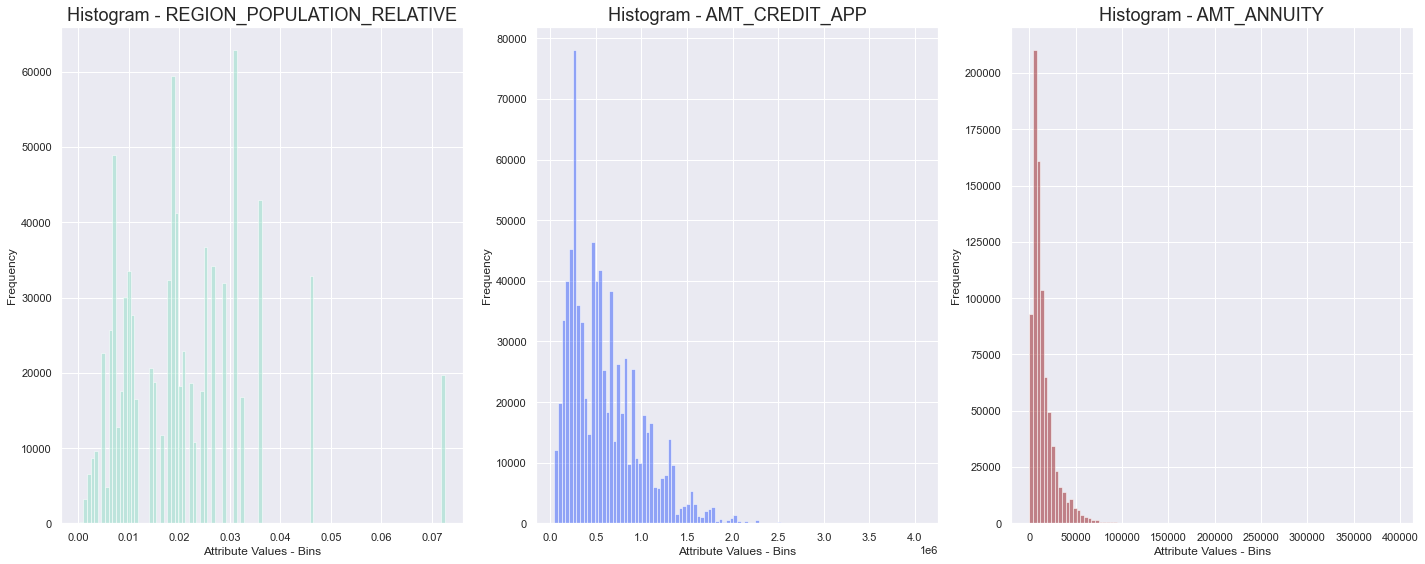

In [75]:
# Histogram plots for all the numeric columns of interest in Approved Target-0 bucket

fig_size = (20, 8)
plot_hist(dict_bucket_tar_0['Approved'], list_numeric, fig_size)

 We can draw the following insights from the histogram for numerical variables:
 
Variable: REGION_POPULATION_RELATIVE - (Normalized population of a region where client lives)

* Two huge peakes can found in the attribute around 0.03 and 0.02 i.e. the normalized region population, which points to the fact the customers living in the region of that relative population have got previous loan approved and are non defaulters.

Variable: AMT_CREDIT_APP - (Amount of credit applied for in the current application)

* Right skewed distribution with a peak around 0.25 suggesting the clients who got the low credit amount are likely to pay the loan on time if their previous loans were approved 

Variable: AMT_ANNUITY - (Annuity for the previous application loan)

* Applicants that have low annuity are more and are likely to repay their loans if they have their previous loan approved already.

###  Plot for the categorical variables in the previous refused and current on time payment(Target=0)

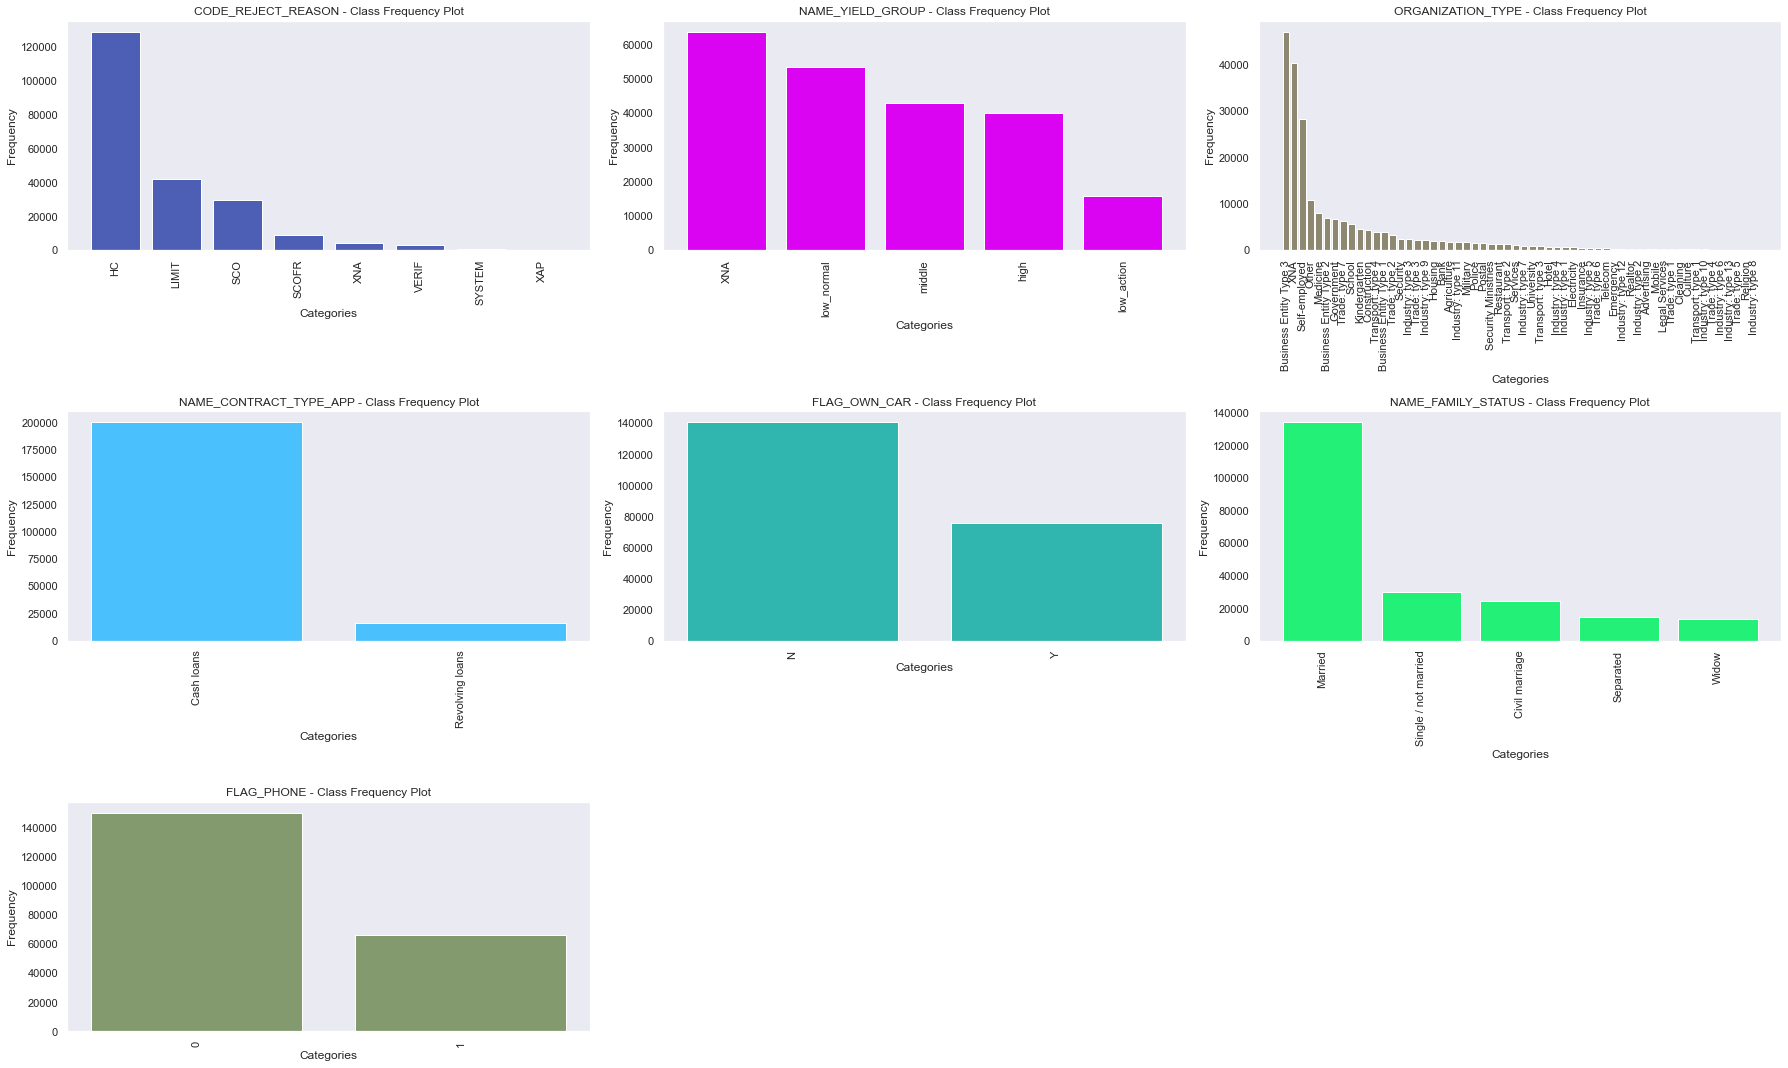

In [76]:
fig_size = (25, 15)
plot_categ(3, 3, dict_bucket_tar_0['Refused'], list_categ, fig_size)

We can draw the following insights from the plots for categorical variable:

Category- CODE_REJECT_REASON 

* Applicants whose previous loan applications were refused were majorly refused because of the reject reason code='HC'. We do not have any specific onto what this value of reject reason code means. But most of the refused loan applications were rejected becuase of this code.
* A very few of the applcations were refused by the reject reason code='SYSTEM'


Category- NAME_YIELD_GROUP 

* For majority of the customers in this population group have missing interest rate(XNA) values , which means the dataset itself needs a correction and going forward we would want to make sure that interest rate is captured for all the customers in the database. IF we do not consider the missing values, low normal interest rates are the ones having highest number of  applicants whose previous loan was refused. 


Category- ORGANIZATION_TYPE 

* The distribution of applicants whose previous applications are refused is somewhat similar to the applicants whose previous loan application was approved. We see that the majority of the clients work for the "BUSINESS ENTITY TYPE 3" which have their previous loans refused but they are likely to pay their current loan on time. Need to be checked further how the organization type helps in identifying the default status of the applicants.

Category- NAME_CONTRACT_TYPE_APP 
* Cash loans were provided for the applicants which have their previous applications refused,  as the plot suggests ere are likely topay their loans on time. Though we will have to check it further since the numbers are high for cash loans  irrespective of the status of the previous loan being approved or rejected. 


Category- FLAG_OWN_CAR 

* More of the loans applicants that were refused in the previous application do not own a car .However the timely payment in the current application suggests more check on this categorical variable.

Category- NAME_FAMILY_STATUS 

* Applicants who are married are more likely to replay thei loans even though their previous application was refused. This is what the graph suggests.However we will have to have further detailed analysis in order to find out the dependency of loan approval on family status as they are currenltly paying off thier loan on a timely basis. There may be other factors involved to identify why the current application of such applicants were approved.

Category- FLAG_PHONE

* similar distribution for the ones whose previous loan application was refused as well as for those whose request was approved. This field doesnt seem to impact the idea of a loan being approved or refused since a huge chunk of the population is who have not given their phone details is paying off the loan without any delay. 

###  Histogram plot for the numerical variable in the previous Refused and current on time payment(Target=0)

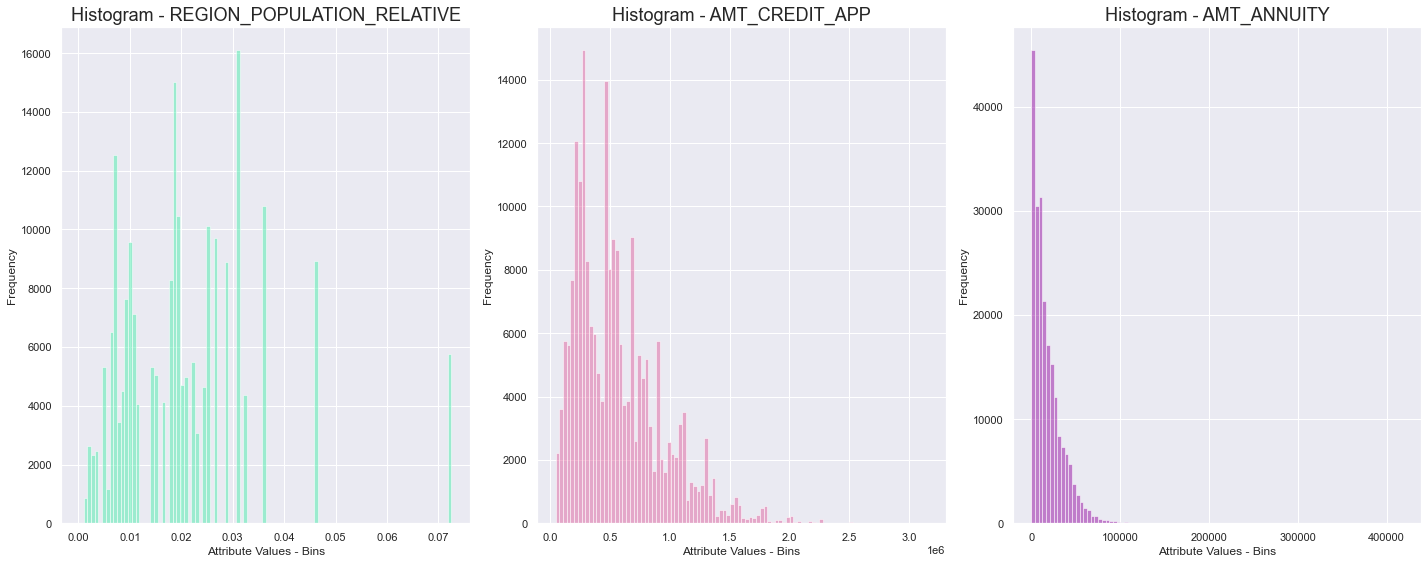

In [77]:
# Histogram plots for all the numeric columns of interest in Refused Target-0 bucket

fig_size = (20, 8)
plot_hist(dict_bucket_tar_0['Refused'], list_numeric, fig_size)

For all the three numerical variables , the trend is similar for the applicants whose  previous application got refused as well as for the ones for whom it was approved

# Bivariate Analysis (target = 1 and previous Approved - FP)

### Let's look at the combination of the above columns to see trends among these sub-groups and define some metrics that correctly measure the reliability of the customer.

### NAME_FAMILY_STATUS with FLAG_OWN_CAR

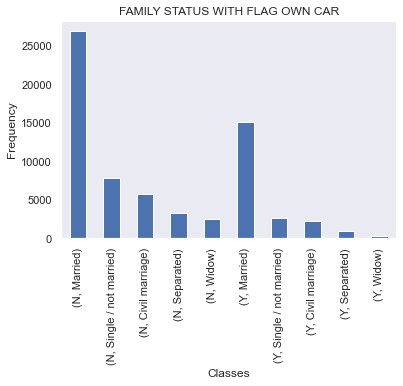

In [78]:
segment = dict_bucket_tru_1['Approved'].groupby(['FLAG_OWN_CAR'])['NAME_FAMILY_STATUS'].value_counts().plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('FAMILY STATUS WITH FLAG OWN CAR')
plt.grid()
plt.show()

### Metric : Married with Car 

### We can simply see the number of customer defaulting for the late payment married but don't own a car while their previous loans were approved. Therefore this gives us one metric to keep a check on before approving the future loans, since these features are contributing to the FPs here.



### NAME_FAMILY_STATUS with ORGANIZATION_TYPE

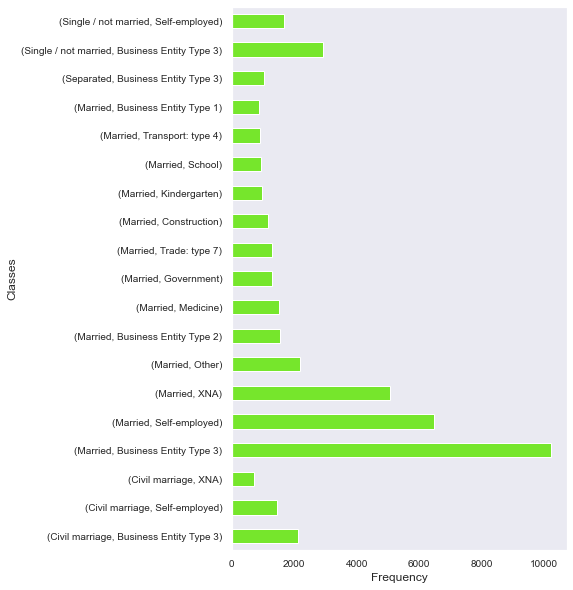

In [79]:
plt.figure(figsize=(6, 10))
segment = dict_bucket_tru_1['Approved'].groupby(['NAME_FAMILY_STATUS'])['ORGANIZATION_TYPE'].value_counts()

# Checking the 90th percentile value for segemented frequency
# will be using it to plot only the categories with significant count, since we don't want to plot all the categories

for key in segment.keys(): 
    if segment[key] < np.percentile(sorted([x for x in segment.values]), 90):
        del segment[key]

segment.plot(kind='barh', color=[random.random() for x in range(3)], fontsize=10)
plt.ylabel('Classes')
plt.xlabel('Frequency')
plt.grid()
plt.show()


### Metric : Family with org type

### Applicants being married and working in organisation type = Business Entity Type and Self employed are the among highest current defaulter with late payments while their previous application loans were approved. So, we need to be keep strict filters for all the applicant who are married and have above mentioned two organisation types.

### We also see that the top 4 default categories are for Married population.

### AMT_CREDIT_APP with AMT_INCOME_TOTAL

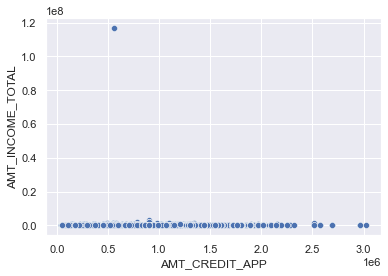

In [80]:
sns.scatterplot(x = "AMT_CREDIT_APP", y = "AMT_INCOME_TOTAL",data=dict_bucket_tru_1['Approved'])
sns.set(style='darkgrid')
plt.show()

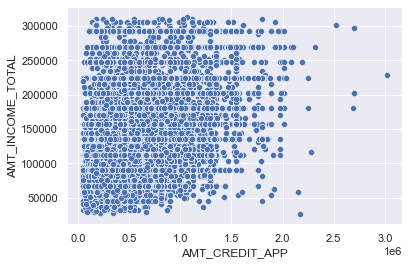

In [81]:
# The above plot's visual interpretation is restricted by the outlier.
# Let's prune the outlier
qntl = dict_bucket_tru_1['Approved']['AMT_INCOME_TOTAL'].quantile(0.95)
data = dict_bucket_tru_1['Approved'][dict_bucket_tru_1['Approved']['AMT_INCOME_TOTAL'] < qntl]
sns.scatterplot(x = "AMT_CREDIT_APP", y = "AMT_INCOME_TOTAL",data=data)
sns.set(style='darkgrid')
plt.show()

 We see the plot's dense region becomes sparse approximately post Rs 20 Lakhs of the applied loan credit. There are a few instances where the application loan is above 20 Lakhs but income of the client is less than 50000.

 Since all these data points belongs to late payment applicants, there is no specific group that can be commented on here that shouldn't be given approval. In the end we can say that, we don't see any correlation between AMT_INCOME_TOTAL and AMT_CREDIT_APP for defaulted customer base.

###  NAME_YIELD_GROUP  with AMT_CREDIT_APP

In [82]:
segment = dict_bucket_tru_1['Approved'].groupby(['NAME_YIELD_GROUP'])['AMT_CREDIT_APP'].describe()

In [83]:
segment

,count,mean,std,min,25%,50%,75%,max
NAME_YIELD_GROUP,,,,,,,,
XNA,7445.0,564132.201679,336198.298231,45000.0,298512.0,509400.0,746280.0,2695500.0
high,22997.0,557838.964495,339226.095990,45000.0,284400.0,497520.0,746280.0,3020760.0
low_action,3616.0,599491.946350,365267.527565,47970.0,312768.0,521280.0,790830.0,2695500.0
low_normal,13317.0,588697.907862,363300.555547,45000.0,297130.5,517923.0,788472.0,2961000.0
middle,19868.0,578720.097795,362109.623658,45000.0,286704.0,508500.0,765000.0,2961000.0


### For all the interest rate groups we see min, max, 25%, 50%, 75% have very similar magnitude value. This points to the fact that the current organisation is not charging interest rate with an optimal strategy. Basically for similar credit amount they are charging different interest rates and the defaults are highest for the high interest rate group as suggested by the count.

In [84]:
segment = dict_bucket_tru_1['Approved'].groupby(['NAME_YIELD_GROUP', 'NAME_FAMILY_STATUS'])['AMT_CREDIT_APP'].describe()

In [85]:
segment

count           mean            std  \
NAME_YIELD_GROUP NAME_FAMILY_STATUS                                            
XNA              Civil marriage          914.0  514371.480853  316225.346501   
                 Married                4699.0  599820.259204  345617.102198   
                 Separated               476.0  508939.960084  301586.099609   
                 Single / not married   1122.0  487012.247326  309656.780158   
                 Widow                   234.0  523889.519231  303533.400156   
high             Civil marriage         2789.0  504666.330764  300511.308165   
                 Married               14080.0  598485.118999  353886.058227   
                 Separated              1470.0  523739.237755  315748.968310   
                 Single / not married   3854.0  468096.636741  293521.798154   
                 Widow                   804.0  523005.817164  331048.818007   
low_action       Civil marriage          383.0  568842.979112  370324.780745   
                 Married                2280.0  627499.186184  368864.288838   
                 Separated               224.0  573975.984375  351122.728426   
                 Single / not married    573.0  519436.774869  352784.670619   
                 Widow                   156.0  596089.615385  313087.521236   
low_normal       Civil marriage         1486.0  532437.541050  339300.235275   
                 Married                8431.0  623948.302752  374659.296323   
                 Separated               863.0  561672.443221  343218.353399   
                 Single / not married   1915.0  498649.678590  315789.928334   
                 Widow                   622.0  560035.786977  356681.966486   
middle           Civil marriage         2294.0  516845.271578  316631.425333   
                 Married               12504.0  620509.295226  377546.400642   
                 Separated              1211.0  523983.964905  324560.905209   
                 Single / not married   2924.0  497441.954856  326095.995057   
                 Widow                   935.0  496743.064171  318611.042368   

                                            min         25%        50%  \
NAME_YIELD_GROUP NAME_FAMILY_STATUS                                      
XNA              Civil marriage         45000.0  284400.000  456612.75   
                 Married                45000.0  318253.500  537669.00   
                 Separated              45000.0  284400.000  450000.00   
                 Single / not married   45000.0  269550.000  420367.50   
                 Widow                  71955.0  271260.000  482271.75   
high             Civil marriage         47970.0  270000.000  450000.00   
                 Married                45000.0  314100.000  523257.75   
                 Separated              45000.0  278709.750  467257.50   
                 Single / not married   45000.0  254700.000  413235.00   
                 Widow                  49752.0  254700.000  454500.00   
low_action       Civil marriage         50940.0  281184.750  497520.00   
                 Married                52128.0  337500.000  545040.00   
                 Separated              90000.0  312690.375  508495.50   
                 Single / not married   47970.0  254700.000  450000.00   
                 Widow                 112500.0  322944.750  560664.00   
low_normal       Civil marriage         45000.0  270000.000  457834.50   
                 Married                47970.0  318528.000  543037.50   
                 Separated              45000.0  296334.000  495000.00   
                 Single / not married   45000.0  267745.500  447768.00   
                 Widow                  45000.0  267343.875  498217.50   
middle           Civil marriage         47970.0  270266.625  467257.50   
                 Married                45000.0  315000.000  539100.00   
                 Separated              45000.0  277123.500  450000.00   
                 Single / not 

We observe in all the family status subgroups within the interest rate group, the married population is the highest defaulter, though their previous loans where approved. Let's try to add another level of subgrouping, is there another variable which to add more information to this.

In [86]:
# Let's check whether applicant owns car or not
dict_bucket_tru_1['Approved'].groupby(['NAME_YIELD_GROUP', 'NAME_FAMILY_STATUS', 'FLAG_OWN_CAR'])['AMT_CREDIT_APP'].describe()


count           mean  \
NAME_YIELD_GROUP NAME_FAMILY_STATUS   FLAG_OWN_CAR                          
XNA              Civil marriage       N              684.0  501211.750000   
                                      Y              230.0  553507.376087   
                 Married              N             3126.0  590916.993282   
                                      Y             1573.0  617513.589955   
                 Separated            N              380.0  502173.082895   
                                      Y               96.0  535725.515625   
                 Single / not married N              876.0  473308.741438   
                                      Y              246.0  535810.097561   
                 Widow                N              219.0  523481.712329   
                                      Y               15.0  529843.500000   
high             Civil marriage       N             2044.0  489596.741683   
                                      Y              745.0  546011.619463   
                 Married              N             8976.0  584960.881684   
                                      Y             5104.0  622269.122551   
                 Separated            N             1110.0  512025.831081   
                                      Y              360.0  559855.575000   
                 Single / not married N             2851.0  458266.809365   
                                      Y             1003.0  496037.651545   
                 Widow                N              730.0  523791.739726   
                                      Y               74.0  515252.797297   
low_action       Civil marriage       N              267.0  535271.696629   
                                      Y              116.0  646114.810345   
                 Married              N             1422.0  612265.284810   
                                      Y              858.0  652746.980769   
                 Separated            N              169.0  543868.215976   
                                      Y               55.0  666488.945455   
                 Single / not married N              405.0  508508.588889   
                                      Y              168.0  545781.508929   
                 Widow                N              144.0  598379.968750   
                                      Y               12.0  568605.375000   
low_normal       Civil marriage       N             1041.0  518108.857349   
                                      Y              445.0  565957.001124   
                 Married              N             5377.0  604270.634462   
                                      Y             3054.0  658593.627701   
                 Separated            N              641.0  553900.682527   
                                      Y              222.0  584112.527027   
                 Single / not married N             1418.0  481798.142454   
                                      Y              497.0  546729.111670   
                 Widow                N              577.0  553480.089255   
                                      Y               45.0  644094.400000   
middle           Civil marriage       N             1633.0  500973.227802   
                                      Y              661.0  556057.143722   
                 Married              N             7977.0  602792.184844   
                                      Y             4527.0  651728.510934   
                 Separated            N              948.0  506072.615506   
                                      Y              263.0  588546.547529   
                 Single / not married N             2199.0  477575.975443   
                                      Y              725.0  557697.525517   
                 Widow                N              860.0  494189.445349   
                                      Y               75.0  526024.560000   

                                                

#### We observe that highest count for defaults across different interest bucket for married applicant who doesn't own a car. The frequency is highest for the high interest rate bucket for married applicant with no car.

#### Inference : The current organisation should lower the interest rates for applicants who are married and have no car, who historically had approved loans. This can help reduce the late payment defaults of the customers.

### Metric : low interest for Married-NoCar

###  REGION_POPULATION_RELATIVE with AMT_INCOME TOTAL

We hypothesised that region population relative attribute could be an indicator which reflect the living standard of the applicant. If the applicant is supposed to be living in a high population density region, it could point to a poor living condition while, if applicant is living in a less populous region, there is a possibility he is living in an opulent environment.

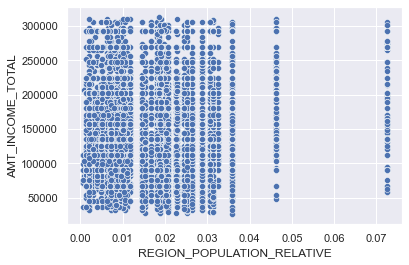

In [87]:
sns.scatterplot(x = "REGION_POPULATION_RELATIVE", y = "AMT_INCOME_TOTAL",data=data)
sns.set(style='darkgrid')
plt.show()

We see the region population relative has no significant relation with the income of the applicant which points to the fact, there is no relation of the region population with living standard of the applicant. So therefore our hypothesis is not probable to be true.

# Bivariate Analysis (target = 0 and previous Refused- False Negatives  )

#### NAME_FAMILY_STATUS with FLAG_OWN_CAR

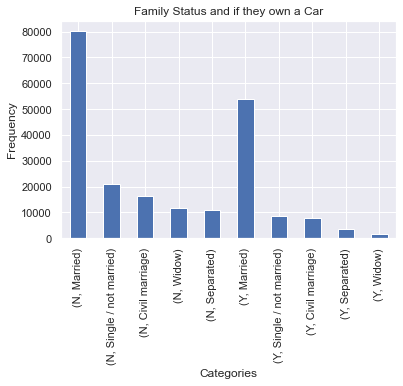

In [88]:

dict_bucket_tar_0['Refused'].groupby(['FLAG_OWN_CAR'])['NAME_FAMILY_STATUS'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Family Status and if they own a Car',size=12)
plt.show()

The population under consideration are the ones whose previous loans got refused and yet they are on-time payers in the current application.
 We can see  that the Married people who do not own a car are the ones likely to pay their loan on time.
Bank **may** consider the loan requests for married people who do not own a car

#### NAME_FAMILY_STATUS with ORGANIZATION_TYPE

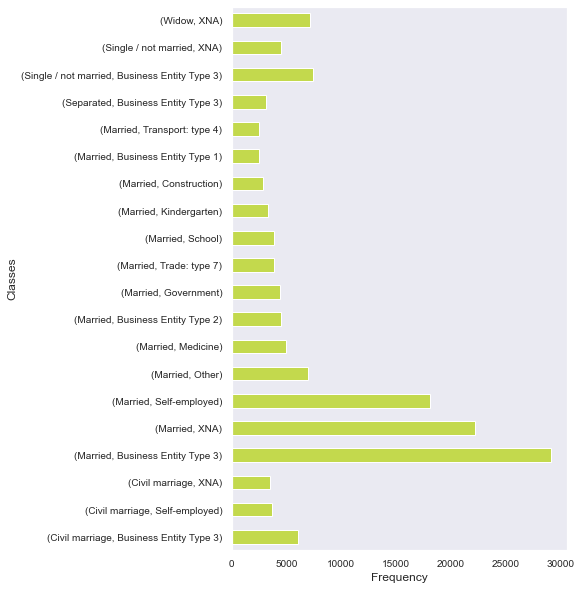

In [89]:
plt.figure(figsize=(6, 10))
segment = dict_bucket_tar_0['Refused'].groupby(['NAME_FAMILY_STATUS'])['ORGANIZATION_TYPE'].value_counts()

# Checking the 90th percentile value for segemented frequency
# will be using it to plot only the categories with significant count, since we don't want to plot all the categories

for key in segment.keys(): 
    if segment[key] < np.percentile(sorted([x for x in segment.values]), 90):
        del segment[key]

segment.plot(kind='barh', color=[random.random() for x in range(3)], fontsize=10)
plt.ylabel('Classes')
plt.xlabel('Frequency')
plt.grid()
plt.show()

In [90]:
# Adding another subgroup- FLAG_OWN_CAR to better understand the distribution of organisation type
dict_bucket_tar_0['Refused'].groupby(['NAME_FAMILY_STATUS', 'FLAG_OWN_CAR'])['ORGANIZATION_TYPE'].describe()



count unique                     top   freq
NAME_FAMILY_STATUS   FLAG_OWN_CAR                                             
Civil marriage       N             16507     57  Business Entity Type 3   3743
                     Y              7821     53  Business Entity Type 3   2281
Married              N             80228     57                     XNA  17158
                     Y             54016     58  Business Entity Type 3  13672
Separated            N             10986     54                     XNA   2739
                     Y              3576     50  Business Entity Type 3    913
Single / not married N             21149     56  Business Entity Type 3   4683
                     Y              8568     56  Business Entity Type 3   2717
Widow                N             11598     50                     XNA   6613
                     Y              1503     39                     XNA    570

Married people who have a car are working for Business Entity Type 3 and are more likely to pay their loans on time. Even though the previous application was refused.
Bank may consider giving loans in the future for those married customers who do own a car as they are more likely to pay off their loans on time.
Similarily  a considerate amount of population who are Single/not married who works for Business Entity Type 3 and also do not own a car, is a chunk that that bank may target for further loan processing.

**METRIC : Single-NoCar**

#### Distribution how the AMT_CREDIT_APP and AMT_INCOME_TOTAL are related

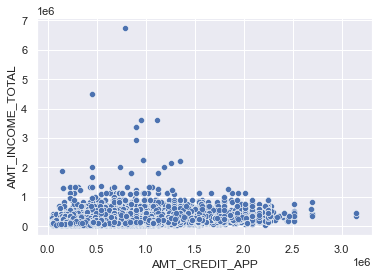

In [91]:
sns.scatterplot(x = "AMT_CREDIT_APP", y = "AMT_INCOME_TOTAL",data=dict_bucket_tar_0['Refused'])
plt.show()

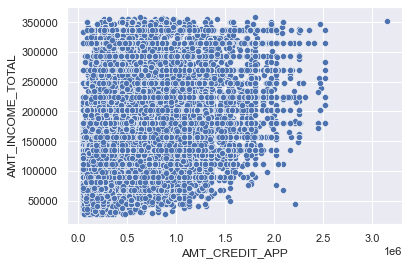

In [92]:
# The above plot's visual interpretation is restricted by the outlier.
# Let's prune the outlier
qntl = dict_bucket_tar_0['Refused']['AMT_INCOME_TOTAL'].quantile(0.95)
data0 = dict_bucket_tar_0['Refused'][dict_bucket_tar_0['Refused']['AMT_INCOME_TOTAL'] < qntl]
sns.scatterplot(x = "AMT_CREDIT_APP", y = "AMT_INCOME_TOTAL",data=data0)
sns.set(style='darkgrid')
plt.show()

* The above population belongs to the non defaulters whose previous loan were refused . The customers who were given loan as per the income range are more likely to pay there loans. 
* The loan applicants who were credited a loan around 25 lakhs, most of the people were of income more than 1.5 lakhs . 
* However there are a few exceptional instance where we can see a 20 lacs loan being provided to people whose income is less than 1 lakhs.
* By seeing the density, Majority of the population who falls under the income category of 50000 were given a credit of 5 lacks

#### NAME_YIELD_GROUP and AMT_CREDIT_APP

In [93]:
dict_bucket_tar_0['Refused'].groupby(['NAME_YIELD_GROUP'])['AMT_CREDIT_APP'].describe()

,count,mean,std,min,25%,50%,75%,max
NAME_YIELD_GROUP,,,,,,,,
XNA,63742.0,530816.121043,350747.100514,45000.0,269550.0,450000.0,687600.0,3150000.0
high,40090.0,546557.822050,359509.002808,45000.0,269550.0,463284.0,753840.0,2517300.0
low_action,15723.0,673012.632227,423022.433345,45000.0,327024.0,584766.0,900000.0,2695500.0
low_normal,53568.0,603047.972866,376861.132959,45000.0,292500.0,526491.0,808650.0,2695500.0
middle,42829.0,551733.449030,360153.282513,45000.0,270000.0,472500.0,752742.0,2695500.0


The majority of the interest rates on the loans that are being payed on time falls under the missing value. The bank needs to capture these details from the customer going forward as they are likely to pay their loans on time. Other than that the high yield group seems less likely to default even when the previous loan applcation was refused.
Other than this we see that the 25%, 50%, 75% have very similar magnitude values for all the groups but the Low Action yield group. However the count is the least for them when compared to the other groups, it may or may not be definite to look for this group by the bank. They may need to consider other factors , but they seem to pay their loans on time.

##### Let us further divide this on the basis of NAME_FAMILY_STATUS to see the amount credit distribution


In [94]:
dict_bucket_tar_0['Refused'].groupby(['NAME_YIELD_GROUP', 'NAME_FAMILY_STATUS'])['AMT_CREDIT_APP'].describe()

count           mean            std  \
NAME_YIELD_GROUP NAME_FAMILY_STATUS                                            
XNA              Civil marriage         6925.0  489116.536895  323022.598076   
                 Married               40569.0  563653.896547  364607.886174   
                 Separated              4131.0  494252.032680  329917.188322   
                 Single / not married   9043.0  446283.179642  294255.007046   
                 Widow                  3074.0  489193.331165  343411.768968   
high             Civil marriage         4535.0  497169.256009  327662.060606   
                 Married               24761.0  582127.539740  374643.333224   
                 Separated              2737.0  515357.021739  332796.754487   
                 Single / not married   5874.0  476446.935138  321238.150189   
                 Widow                  2183.0  473476.423729  320880.826713   
low_action       Civil marriage         1861.0  666112.536271  437991.743145   
                 Married                9968.0  700209.285313  428046.076404   
                 Separated               974.0  641802.497433  398722.891466   
                 Single / not married   1964.0  593522.537169  404805.520787   
                 Widow                   956.0  597972.944561  365892.639603   
low_normal       Civil marriage         6167.0  567482.342063  360354.773383   
                 Married               33205.0  636326.805933  387477.854329   
                 Separated              3569.0  574191.752732  359238.474700   
                 Single / not married   6686.0  529512.648370  346173.282769   
                 Widow                  3941.0  529197.331515  339883.679202   
middle           Civil marriage         4840.0  506625.017355  328117.996732   
                 Married               25741.0  593843.694534  375640.599986   
                 Separated              3151.0  513683.838623  340062.598964   
                 Single / not married   6150.0  474454.003171  314611.015920   
                 Widow                  2947.0  459954.655073  323175.425553   

                                           min         25%       50%  \
NAME_YIELD_GROUP NAME_FAMILY_STATUS                                    
XNA              Civil marriage        45000.0  254700.000  415408.5   
                 Married               45000.0  270000.000  490536.0   
                 Separated             45000.0  247675.500  444420.0   
                 Single / not married  45000.0  238500.000  382500.0   
                 Widow                 45000.0  247500.000  403290.0   
high             Civil marriage        45000.0  254700.000  444420.0   
                 Married               45000.0  273024.000  508495.5   
                 Separated             45000.0  254700.000  454500.0   
                 Single / not married  45000.0  254700.000  405000.0   
                 Widow                 45000.0  227520.000  390960.0   
low_action       Civil marriage        45000.0  325908.000  545040.0   
                 Married               45000.0  343800.000  625536.0   
                 Separated             45000.0  308133.000  560664.0   
                 Single / not married  45000.0  270000.000  500211.0   
                 Widow                 50940.0  293866.875  539100.0   
low_normal       Civil marriage        45000.0  274068.000  497520.0   
                 Married               45000.0  315000.000  545040.0   
                 Separated             45000.0  270000.000  508495.5   
                 Single / not married  45000.0  261000.000  450000.0   
                 Widow                 45000.0  254700.000  454500.0   
middle           Civil marriage        45000.0  261000.000  450000.0   
                 Married               45000.0  286704.000  518562.0   
                 Separated             45000.0  252130.500  450000.0   
                 Single / not married  45000.0  247331.250  405000.0   
        

The count of married people seems to have the most number of on time payments irrespective of the interest rates yield group even if their previous loans were refused.

Let us divide this further on FLAG_OWN_CAR to make some conclusions how the married people are more likely to repay their loans on time

In [95]:
# Let's check whether applicant owns car or not
dict_bucket_tar_0['Refused'].groupby(['NAME_YIELD_GROUP', 'NAME_FAMILY_STATUS', 'FLAG_OWN_CAR'])['AMT_CREDIT_APP'].describe()


count           mean  \
NAME_YIELD_GROUP NAME_FAMILY_STATUS   FLAG_OWN_CAR                           
XNA              Civil marriage       N              4732.0  472722.596893   
                                      Y              2193.0  524490.966484   
                 Married              N             24622.0  543232.582731   
                                      Y             15947.0  595184.189942   
                 Separated            N              2998.0  477760.051201   
                                      Y              1133.0  537891.009267   
                 Single / not married N              6313.0  429821.538809   
                                      Y              2730.0  484349.970330   
                 Widow                N              2681.0  473371.598471   
                                      Y               393.0  597127.339695   
high             Civil marriage       N              3112.0  481201.289364   
                                      Y              1423.0  532090.065706   
                 Married              N             14882.0  560551.608554   
                                      Y              9879.0  614630.121773   
                 Separated            N              2029.0  500200.356580   
                                      Y               708.0  558793.283898   
                 Single / not married N              4227.0  464738.622072   
                                      Y              1647.0  506496.139344   
                 Widow                N              1970.0  468479.444162   
                                      Y               213.0  519692.619718   
low_action       Civil marriage       N              1204.0  637096.877492   
                                      Y               657.0  719285.828767   
                 Married              N              5553.0  679239.880875   
                                      Y              4415.0  726583.714043   
                 Separated            N               723.0  606373.188797   
                                      Y               251.0  743855.844622   
                 Single / not married N              1308.0  567843.247706   
                                      Y               656.0  644724.535061   
                 Widow                N               829.0  581421.826900   
                                      Y               127.0  706011.342520   
low_normal       Civil marriage       N              4150.0  544188.739880   
                                      Y              2017.0  615409.188399   
                 Married              N             19795.0  608905.473554   
                                      Y             13410.0  676804.455034   
                 Separated            N              2698.0  555647.949407   
                                      Y               871.0  631632.833525   
                 Single / not married N              4772.0  516817.614417   
                                      Y              1914.0  561164.007837   
                 Widow                N              3481.0  519074.773772   
                                      Y               460.0  605798.686957   
middle           Civil marriage       N              3309.0  494278.400725   
                                      Y              1531.0  533310.160679   
                 Married              N             15376.0  572238.342417   
                                      Y             10365.0  625894.239074   
                 Separated            N              2538.0  502246.714539   
                                      Y               613.0  561036.890701   
                 Single / not married N              4529.0  456919.997461   
                                      Y              1621.0  523443.214682   
                 Widow                N              2637.0  450792.556314   
                                      Y               310.0  537891.604839  

Okay, so we found out that the married people who do not own a car and have been provided low normal interest rates are the ones likely to pay the loans on time even when the previous loan was refused, followed by the married people who do not own a car and provided middle interest rates and followed by the ones who are given high interest rates.
So we can conclude, that married people with no car are the ones less likely to default, so the bank can consider them for future loans.


**METRIC : Married No-cars**

####  REGION_POPULATION_RELATIVE with AMT_INCOME TOTAL

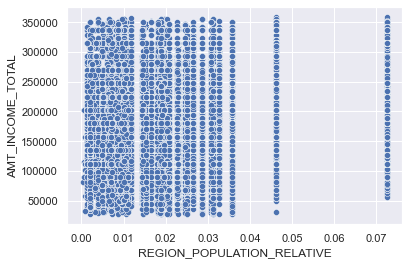

In [96]:

qntl = dict_bucket_tar_0['Refused']['AMT_INCOME_TOTAL'].quantile(0.95)
data0 = dict_bucket_tar_0['Refused'][dict_bucket_tar_0['Refused']['AMT_INCOME_TOTAL'] < qntl]

sns.scatterplot(x = "REGION_POPULATION_RELATIVE", y = "AMT_INCOME_TOTAL",data=data0)
plt.show()

As We hypothesised  earlier that region population relative attribute could be an indicator which reflect the living standard of the applicant. we could find that there is no significant relation between the region population relative  and  the income of the applicant which points to the fact, there is no relation of the region population with living standard of the applicant. So therefore our hypothesis is not probable to be true.

## Conclusion

### Top Five Indicators

After the correlation analysis w.r.t the target variabel, we found following variables in the top 5 of the list: 

* EXT_SOURCE_2

* EXT_SOURCE_3 

* CODE_REJECT_REASON 

* REGION_POPULATION_RELATIVE 

* NAME_YIELD_GROUP

### False Positive - How to reduce it!! 

From the above analysis, we came up with **some metrics** defined using the attributes in the dataset which helps us reduce the false positives i.e. previously approved loans defaulting in current loans.

METRICS ====================>

* **Low interest for Married-NoCar** : The organisation should lower the interest rates for the Married individual who don't own a car to reduce the payment defaults.

* **Family with org type** : Married and working with business entity type = 3 and self employeed customers need strict filters before being given a green flag for the loan. It will help reduce the false positives.

### False Negative - How to reduce it!! 

From the above analysis we came up with **some metrics** defined using the attributes in the dataset which helps us reduce the false positives i.e. previously refused loans but donot default in the current application.

METRICS ====================>

* **Single No-Car** : The organisation should increase the approval rate for single applicants who don't own a car, since they are able to make payments on time in the current loan while they were refused the loans previously.

* **Married No-Car** : The married applicant with no car are the ones less likely to default, so the bank can consider them for future loans.